# Explore convection on a small discrete square grid 
### with fixed area coverage of discrete updrafts 

Fields b and w might be continuous, although we rank-sort w to have exactly 4 discrete Boolean updrafts. Those can have 16 choose 4 configurations. Many of these are redundant. Explore this redundancy using fft2 (spatial symmetries of transposition and rotation). How big is configuration space, what KE is implied by each, etc. Is there an adjacency function of configuration space, and a function on that space for efficiency (fitness) ? 


In [392]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import label, generate_binary_structure
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy.signal import convolve2d # to find n_neighbors 

In [430]:
# Functions for plotting, n_neighbors, labelcount (#blobs)

def tileplot(arr,N=2, **kwargs): 
    plt.figure( figsize=(2,2))
    plt.pcolormesh( np.tile(arr, (N, N)), cmap='RdBu_r', shading='nearest', \
                    vmin=-np.max(np.abs(arr)),vmax=np.max(np.abs(arr)), **kwargs);
    
def tilecon(arr,N=2, NLEV=23, **kwargs): 
    plt.contourf( np.tile(arr, (N, N)), cmap='RdBu_r',levels=NLEV, **kwargs);
    
def tilequiv(u,v,N=2, pivot='mid', **kwargs): 
    plt.quiver( np.tile(u, (N, N)), np.tile(v, (N, N)), **kwargs);

def labelcount (arr,N=2, **kwargs): 
    return label( np.tile(arr, (N, N)), **kwargs)[1]

def labelcount_diag (arr,N=2, **kwargs): 
    s = generate_binary_structure(2,2)
    return label( np.tile(arr, (N, N)), structure=s, **kwargs)[1]

def n_neighbors(w, max=4):
    # default case: 4 neighbors
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]      ])
    if (max==8): 
        kernel = np.ones((3, 3)); kernel[1, 1] = 0  # Exclude the center cell itself
    if (max==9): 
        kernel = np.ones((3, 3))
   
    # Apply the convolution
    neigh = convolve2d(w, kernel, mode='same', boundary='wrap')
    return(neigh)

In [255]:
# Fourier transform of w returns what, Chi, u, v

def what_Chi_u_v(w):
    
    what = np.fft.fft2(w-np.mean(w))  # Subtract the mean 
    ky, kx = np.fft.fftfreq(w.shape[0]), np.fft.fftfreq(w.shape[1])
    ky2,kx2 = np.meshgrid(ky, kx, indexing='ij')
    kk2 = np.sqrt(kx2**2 + ky2**2)
    
    Chi = np.fft.fft2 (what / (kk2+1e-9)) # Division by zero avoided, only occurs for what=0
    
    Chi = np.roll( np.flipud( np.fliplr(Chi)) ,(1,1),axis=(0,1))  # Graphical fix! Kangfirmed!
    
    # Adjust the boundaries for periodicity and compute gradient, then trim it 
    Chi_padded = np.pad(Chi.real, ((1, 1), (1, 1)), mode='wrap')
    grad_x, grad_y = np.gradient(Chi_padded)
    v = grad_x[1:-1, 1:-1]
    u = grad_y[1:-1, 1:-1]
    
    # KE once we trust it 
    KE = (u**2 + v**2)/2

    return what,Chi,u,v

In [413]:
NX = 4 # Size of convection field 
NCELLS = 4

b = np.zeros((NX,NX))
w = np.zeros((NX,NX))

w.ravel()[np.random.choice(NX*NX, NCELLS, replace=False)] = 1

In [414]:
what,Chi,u,v = what_Chi_u_v(w)

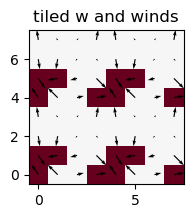

In [422]:
tileplot(w,2); tilequiv( u,v,2 ); plt.title('tiled w and winds');

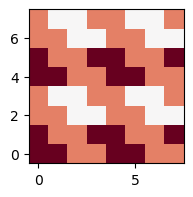

In [434]:
tileplot(n_neighbors(w)) #; plt.colorbar();

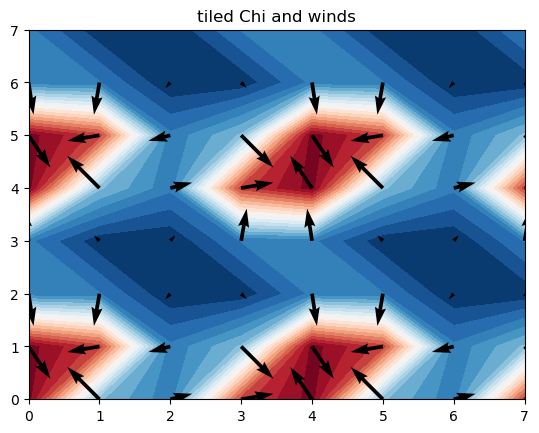

In [423]:
tilecon(Chi.real,2); tilequiv( u,v,2 ); plt.title('tiled Chi and winds');

In [424]:
labelcount(w,10)/100   # 10 periodic tiles: swamp out edge effects

1.1

In [425]:
labelcount_diag(w,10)/100   # 10 periodic tiles: swamp edge effects

1.1

# How many unique configurations are possible?

For a given periodic domain size, how many distinct configs are there? Math could perhaps count the equivalency classes, with the number of transpositions = NX + NY and the number of rotations = 4, but some of those are perhaps redundant...confused about it, let's see what the numbers say, especially cared-about things like KE or mean wind speed. 

**MeanVs** seems to be the most discriminating quantity about a configuration

The formula for combinations without replacement (AS HERE) is:
`C(n,r)= r!(n−r)! / n!`

The formula for combinations with replacement is:
`C′(n,r)= r!(n−1)!/(n+r−1)!`


In [426]:
from scipy.special import comb

# Calculate combinations of 16 choose 4
n = 16; k = 4
print(comb(n, k))   # repetition=True for selection WITH replacement

1820.0


In [427]:
# Unique combinations if there are 4+4 translations and 4 rotations
n = 16; k = 4
print( comb(n, k) /k/k/4. ) # "asymptotes to 29 for NX=NCELLS=4" numerically

28.4375


In [428]:
# Unique combinations if there are k+k translations and 4 rotations
n = 25; k = 5
print( comb(n, k) /k/k/4. )  # "asymptotes to 306 for NX=NCELLS=5" numerically

531.3


KEs unique values: 17
MeanVs unique values: 29
Meanwhats unique values: 8
Nblobs unique values: 11
Nblobs_diag unique values: 22


<Figure size 1200x1200 with 0 Axes>

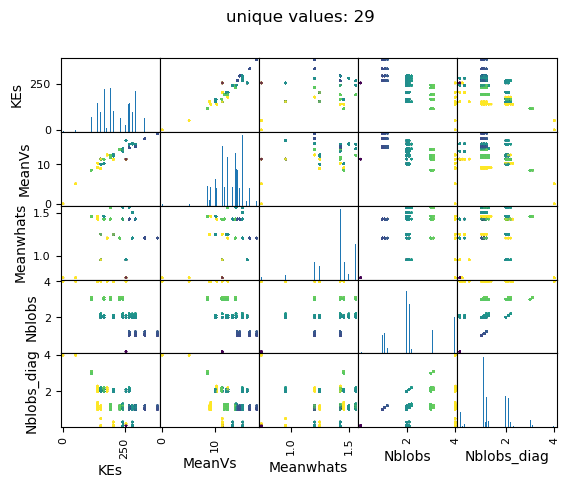

In [391]:
# Make N random configurations and collect KE, etc. 
NX = 4; NCELLS = NX
NSAMP = 10000  # asymptotes to 29 for NX=NCELLS=4, 306 for 5, 5149?(500000) for 6

#initialise list of features
# Spatial contiguity from labeling 
Nblobs= []
Nblobs_diag= []
KEs = []
MeanVs = []
#Powers = [] always the same, Parsevals theorem
Meanwhats=[]

for icon in range(NSAMP):
    w = np.zeros((NX,NX))
    w.ravel()[np.random.choice(NX*NX, NCELLS, replace=False)] = 1
    what,Chi,u,v = what_Chi_u_v(w)

    KE = (u**2 + v**2)/2 # array
    
    KEs.append( np.mean(KE) )
    MeanVs.append( np.mean( np.sqrt(KE) ) ) 
    #Powers.append( np.mean( np.abs(what)**2 )  ) # var(w), always identical!
    Meanwhats.append( np.mean( np.abs(what) )  ) 
    Nblobs.append( labelcount(w,10)/100.  ) # 10 periodic tiles: swamp edge effects
    Nblobs_diag.append( labelcount_diag(w,10)/100.  ) # 10 periodic tiles: swamp edge effects

df = pd.DataFrame({
    'KEs': KEs,
    'MeanVs': MeanVs,
    'Meanwhats': Meanwhats,
    'Nblobs': Nblobs, 
    'Nblobs_diag': Nblobs_diag

})

plt.figure( figsize=(12,12) );
scatter_matrix(df, hist_kwds={'bins': 100}, s=10, c=df.Nblobs);
plt.suptitle('unique values: '+str(np.unique(df.MeanVs.round(decimals=3)).size) );

for key in df.keys():
    print(key+' unique values: '+str(np.unique(df[key].round(decimals=3)).size))

## Time transitions
#### at time t, local cell probability of getting a w (top 4 win): 

$p(w) = W \cdot windspeed(t-1) + B \cdot N_{neighbors}(t-1) + R \cdot random$

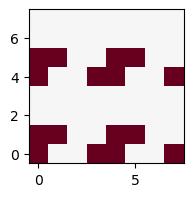

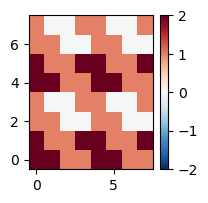